In [2]:
import argparse
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import azureml.core
from azureml.core import Experiment,Workspace, Run
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.train.dnn import TensorFlow
from azureml.train.estimator import Estimator
from azureml.widgets import RunDetails
from collections import defaultdict, Counter
import cv2
import glob
from imblearn.over_sampling import RandomOverSampler
import json
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from numpy import genfromtxt, isnan
from operator import concat
import os
import pandas as pd
import pickle
from PIL import Image, ImageFilter
#from pycocotools.coco import COCO
import pydot
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Flatten, Dropout, GaussianNoise, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import SGD
from skimage import io as io
from skimage import exposure
from skimage.transform import resize, integral_image
from skimage.color import rgb2gray
from skimage.feature import blob_dog, blob_log, blob_doh, daisy, hog, multiblock_lbp, haar_like_feature

from sklearn.dummy import DummyClassifier
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_similarity_score, average_precision_score, f1_score, precision_score, hamming_loss, hinge_loss, recall_score, roc_curve
from sklearn.svm import SVC,LinearSVC
from sklearn.utils import check_random_state

import shutil
import tensorflow as tf
from time import time
import traceback
import timeit
import urllib.request
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import random
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
import seaborn as sns
import umap.umap_ as umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from skmultilearn.model_selection import iterative_train_test_split
np.set_printoptions(threshold=np.inf)
import re
from ast import literal_eval
from sklearn.utils.multiclass import unique_labels
from pylab import rcParams
from statistics import stdev, mean

Using TensorFlow backend.


In [98]:
confmat =  """          
[   0 1843    0    0    0    0    0    0    0    0   17    0   56    0
     0  171    0    0    0    0    0   29    0    0    0    0    0    0
     0    6    0   72    0    0   70    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   12    0    0    0
     0    0    0   59    0    0    0    0   31    0   63    0   20    0
     0    0    0    0    0    0    0    0    0   25]
 [   0   38    0    0    0    0    0    0    0    0  456    0   27    0
     0   36    0    0    0    0    0    4    0    0    0    0    0    0
     0    4    0   13    0    0   11    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   15    0    0    0
     0    0    0   13    0    0    0    0    8    0    0    0    9    0
     0    0    0    0    0    0    0    0    0   16]
 [   0   55    0    0    0    0    0    0    0    0   28    0  260    0
     0   27    0    0    0    0    0    1    0    0    0    0    0    0
     0    5    0   21    0    0    8    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    5    0    0    0
     0    0    0   24    0    0    0    0   29    0   18    0   12    0
     1    0    0    0    0    0    0    0    0   18]
 [   0  161    0    0    0    0    0    0    0    0   19    0   23    0
     0 1022    0    0    0    0    0   57    0    0    0    0    0    0
     0   20    0   38    0    0   28    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   55    0    0    0
     0    0    0  122    0    0    0    0   54    0   42    0   11    0
     0    0    0    0    0    0    0    0    0   17]
 [   0   49    0    0    0    0    0    0    0    0    3    0    9    0
     0  163    0    0    0    0    0  161    0    0    0    0    0    0
     0    5    0    4    0    0    9    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    7    0    0    0
     0    0    0   18    0    0    0    0   20    0    8    0    1    0
     0    0    0    0    0    0    0    0    0    5]
 [   0    4    0    0    0    0    0    0    0    0    6    0    6    0
     0   17    0    0    0    0    0    1    0    0    0    0    0    0
     0  645    0   21    0    0   20    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   69    0    0    0
     0    0    0   35    0    0    0    0   55    0   21    0    1    0
     0    0    0    0    0    0    0    0    0   34]
 [   0   72    0    0    0    0    0    0    0    0    4    0   10    0
     0   59    0    0    0    0    0    5    0    0    0    0    0    0
     0    9    0  474    0    0   38    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    6    0    0    0
     0    0    0   40    0    0    0    0   18    0   26    0    8    0
     0    0    0    0    0    0    0    0    0   25]
 [   0   48    0    0    0    0    0    0    0    0   18    0    8    0
     0   33    0    0    0    0    0    2    0    0    0    0    0    0
     0   25    0   53    0    0  663    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   15    0    0    0
     0    0    0   15    0    0    0    0   22    0   21    0   10    0
     0    0    0    0    0    0    0    0    0   89]
 [   0   12    0    0    0    0    0    0    0    0    9    0    2    0
     0   86    0    0    0    0    0    7    0    0    0    0    0    0
     0   56    0   11    0    0   25    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  703    0    0    0
     0    0    0   52    0    0    0    0   19    0   20    0    1    0
     0    0    0    0    0    0    0    0    0   18]
 [   0  141    0    0    0    0    0    0    0    0   19    0   19    0
     0  341    0    0    0    0    0   11    0    0    0    0    0    0
     0   24    0   64    0    0   46    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   70    0    0    0
     0    0    0  515    0    0    0    0   42    0   79    0   26    0
     1    0    0    0    0    0    0    0    0   52]
 [   0    9    0    0    0    0    0    0    0    0    7    0   15    0
     0   71    0    0    0    0    0    4    0    0    0    0    0    0
     0   61    0   15    0    0   17    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   22    0    0    0
     0    0    0   29    0    0    0    0  525    0   41    0   10    0
     0    0    0    0    0    0    0    0    0   25]
 [   0   49    0    0    0    0    0    0    0    0    8    0   12    0
     0   70    0    0    0    0    0    4    0    0    0    0    0    0
     0   34    0   40    0    0   24    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   28    0    0    0
     0    0    0   46    0    0    0    0   61    0  587    0   40    0
     0    0    0    0    0    0    0    0    0   25]
 [   0   22    0    0    0    0    0    0    0    0    7    0   21    0
     0   34    0    0    0    0    0    4    0    0    0    0    0    0
     0    5    0   14    0    0    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    3    0    0    0
     0    0    0   16    0    0    0    0   10    0   26    0  362    0
     3    0    0    0    0    0    0    0    0    9]
 [   0    8    0    0    0    0    0    0    0    0    2    0    7    0
     0    7    0    0    0    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    2    0    0    0
     0    0    0    7    0    0    0    0    6    0    6    0   26    0
     3    0    0    0    0    0    0    0    0    2]
 [   0    4    0    0    0    0    0    0    0    0    2    0    2    0
     0   14    0    0    0    0    0    4    0    0    0    0    0    0
     0    3    0    3    0    0    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    5    0    0    0
     0    0    0   13    0    0    0    0    9    0    1    0    3    0
     0    0    0    0    0    0    0    0    0    8]
 [   0   26    0    0    0    0    0    0    0    0   17    0   13    0
     0   37    0    0    0    0    0    2    0    0    0    0    0    0
     0   27    0   34    0    0  120    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   41    0    0    0
     0    0    0   39    0    0    0    0   28    0   15    0    5    0
     0    0    0    0    0    0    0    0    0  230]]














"""

confmat = re.sub('\s+', ',', confmat)
confmat = confmat.replace(',[[', '')
confmat = confmat.replace(']],', '')
confmat = confmat.replace('],[,', '\n')

In [107]:
clean_array = []
positions = [1,10,12,15,21,29,31,34,52,59,64,66,68,70,78,79]
for row in data:
    clean_subarray = []
    for position in positions:
        clean_subarray.append(int(row[position]))
    clean_array.append(clean_subarray)
print(clean_array)

[[1843, 17, 56, 171, 29, 6, 72, 70, 12, 59, 31, 63, 20, 0, 0, 25], [38, 456, 27, 36, 4, 4, 13, 11, 15, 13, 8, 0, 9, 0, 0, 16], [55, 28, 260, 27, 1, 5, 21, 8, 5, 24, 29, 18, 12, 1, 0, 18], [161, 19, 23, 1022, 57, 20, 38, 28, 55, 122, 54, 42, 11, 0, 0, 17], [49, 3, 9, 163, 161, 5, 4, 9, 7, 18, 20, 8, 1, 0, 0, 5], [4, 6, 6, 17, 1, 645, 21, 20, 69, 35, 55, 21, 1, 0, 0, 34], [72, 4, 10, 59, 5, 9, 474, 38, 6, 40, 18, 26, 8, 0, 0, 25], [48, 18, 8, 33, 2, 25, 53, 663, 15, 15, 22, 21, 10, 0, 0, 89], [12, 9, 2, 86, 7, 56, 11, 25, 703, 52, 19, 20, 1, 0, 0, 18], [141, 19, 19, 341, 11, 24, 64, 46, 70, 515, 42, 79, 26, 1, 0, 52], [9, 7, 15, 71, 4, 61, 15, 17, 22, 29, 525, 41, 10, 0, 0, 25], [49, 8, 12, 70, 4, 34, 40, 24, 28, 46, 61, 587, 40, 0, 0, 25], [22, 7, 21, 34, 4, 5, 14, 3, 3, 16, 10, 26, 362, 3, 0, 9], [8, 2, 7, 7, 1, 0, 0, 1, 2, 7, 6, 6, 26, 3, 0, 2], [4, 2, 2, 14, 4, 3, 3, 3, 5, 13, 9, 1, 3, 0, 0, 8], [26, 17, 13, 37, 2, 27, 34, 120, 41, 39, 28, 15, 5, 0, 0, 230]]


TypeError: expected string or bytes-like object

In [122]:
confmat =  """          
[[1843, 17, 56, 171, 29, 6, 72, 70, 12, 59, 31, 63, 20, 0, 0, 25]
[38, 456, 27, 36, 4, 4, 13, 11, 15, 13, 8, 0, 9, 0, 0, 16]
[55, 28, 260, 27, 1, 5, 21, 8, 5, 24, 29, 18, 12, 1, 0, 18]
[161, 19, 23, 1022, 57, 20, 38, 28, 55, 122, 54, 42, 11, 0, 0, 17]
[49, 3, 9, 163, 161, 5, 4, 9, 7, 18, 20, 8, 1, 0, 0, 5]
[4, 6, 6, 17, 1, 645, 21, 20, 69, 35, 55, 21, 1, 0, 0, 34]
[72, 4, 10, 59, 5, 9, 474, 38, 6, 40, 18, 26, 8, 0, 0, 25]
[48, 18, 8, 33, 2, 25, 53, 663, 15, 15, 22, 21, 10, 0, 0, 89]
[12, 9, 2, 86, 7, 56, 11, 25, 703, 52, 19, 20, 1, 0, 0, 18]
[141, 19, 19, 341, 11, 24, 64, 46, 70, 515, 42, 79, 26, 1, 0, 52]
[9, 7, 15, 71, 4, 61, 15, 17, 22, 29, 525, 41, 10, 0, 0, 25]
[49, 8, 12, 70, 4, 34, 40, 24, 28, 46, 61, 587, 40, 0, 0, 25]
[22, 7, 21, 34, 4, 5, 14, 3, 3, 16, 10, 26, 362, 3, 0, 9]
[8, 2, 7, 7, 1, 0, 0, 1, 2, 7, 6, 6, 26, 3, 0, 2]
[4, 2, 2, 14, 4, 3, 3, 3, 5, 13, 9, 1, 3, 0, 0, 8]
[26, 17, 13, 37, 2, 27, 34, 120, 41, 39, 28, 15, 5, 0, 0, 230]]














"""

confmat = re.sub('\s+', ',', confmat)
confmat = confmat.replace(',[[', '')
confmat = confmat.replace(']],', '')
confmat = confmat.replace('],[,', '\n')
with open("testresults.txt", "w") as text_file:
    text_file.write(confmat)

In [129]:
data = np.genfromtxt('testresults.txt', delimiter=',')

In [130]:
def convertConfusionMatrix(mat):
    true_labels = []
    predicted_labels = []
    for (i,row) in enumerate(mat):
        print(row)
        true_labels.extend([i+1 for x in range(int(np.sum(row)))])
        print(row)
        for j in range(0, len(row)):
            predicted_labels.extend([j+1 for x in range(int(row[j]))])
    return true_labels, predicted_labels

In [153]:
true_labels, predicted_labels = convertConfusionMatrix(data)
print(true_labels)
print("@@@@@@@@@@@@@@@@")
print(predicted_labels)
print(classification_report(true_labels, predicted_labels, digits=3))

[1843.   17.   56.  171.   29.    6.   72.   70.   12.   59.   31.   63.
   20.    0.    0.   25.]
[1843.   17.   56.  171.   29.    6.   72.   70.   12.   59.   31.   63.
   20.    0.    0.   25.]
[ 38. 456.  27.  36.   4.   4.  13.  11.  15.  13.   8.   0.   9.   0.
   0.  16.]
[ 38. 456.  27.  36.   4.   4.  13.  11.  15.  13.   8.   0.   9.   0.
   0.  16.]
[ 55.  28. 260.  27.   1.   5.  21.   8.   5.  24.  29.  18.  12.   1.
   0.  18.]
[ 55.  28. 260.  27.   1.   5.  21.   8.   5.  24.  29.  18.  12.   1.
   0.  18.]
[ 161.   19.   23. 1022.   57.   20.   38.   28.   55.  122.   54.   42.
   11.    0.    0.   17.]
[ 161.   19.   23. 1022.   57.   20.   38.   28.   55.  122.   54.   42.
   11.    0.    0.   17.]
[ 49.   3.   9. 163. 161.   5.   4.   9.   7.  18.  20.   8.   1.   0.
   0.   5.]
[ 49.   3.   9. 163. 161.   5.   4.   9.   7.  18.  20.   8.   1.   0.
   0.   5.]
[  4.   6.   6.  17.   1. 645.  21.  20.  69.  35.  55.  21.   1.   0.
   0.  34.]
[  4.   6.   6.  17.   

In [142]:
classes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]
true_labels = label_binarize(true_labels, classes=classes)
predicted_labels = label_binarize(predicted_labels, classes=classes)
n_classes = 80
lw = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip([0], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class NN TOMEK links 10% ROC')
plt.legend(loc="lower right")
plt.show()

ValueError: classes [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80] missmatch with the labels [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]found in the data

0.7409487273881967


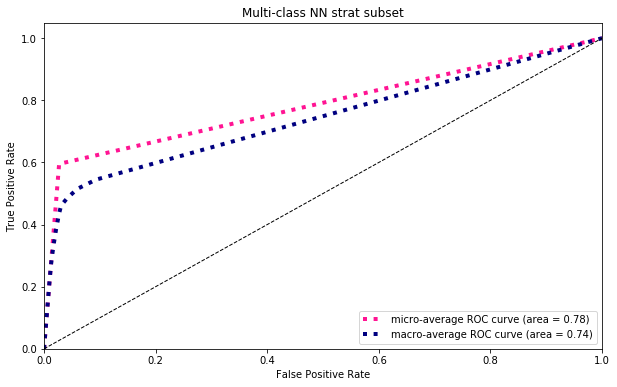

In [156]:
classes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
true_labels = label_binarize(true_labels, classes=classes)
predicted_labels = label_binarize(predicted_labels, classes=classes)
n_classes = 16
lw = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr

roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(roc_auc["macro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class NN strat subset')
plt.legend(loc="lower right")
plt.show()

In [ ]:
classes=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]
true_labels = label_binarize(true_labels, classes=classes)
predicted_labels = label_binarize(predicted_labels, classes=classes)
n_classes = 80
lw = 1
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip([0], colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class NN TOMEK links 10% ROC')
plt.legend(loc="lower right")
plt.show()

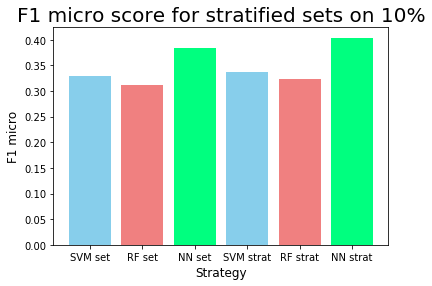

In [13]:
height = [0.330, 0.311, 0.383, 0.337, 0.323, 0.404]
city=['SVM set','RF set','NN set','SVM strat','RF strat','NN strat']
pos = np.arange(len(height))
colors = ['skyblue', 'lightcoral', 'springgreen']
plt.bar(pos,height,color=colors)
plt.xticks(pos, city)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('F1 micro', fontsize=12)
plt.title('F1 micro score for stratified sets on 10%',fontsize=20)
plt.show()

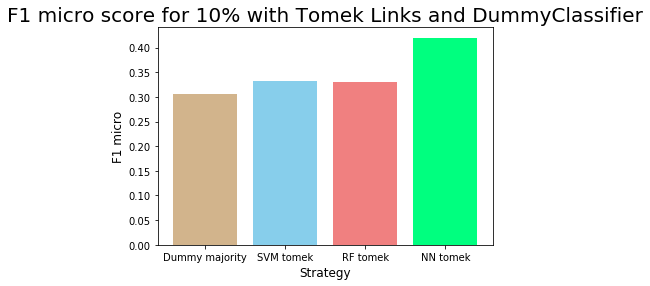

In [29]:
height = [0.306, 0.333, 0.331, 0.420]
city=['Dummy majority','SVM tomek','RF tomek','NN tomek']
pos = np.arange(len(height))
colors = ['tan', 'skyblue', 'lightcoral', 'springgreen']
plt.bar(pos,height,color=colors)
plt.xticks(pos, city)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('F1 micro', fontsize=12)
plt.title('F1 micro score for 10% with Tomek Links and DummyClassifier',fontsize=20)
plt.show()

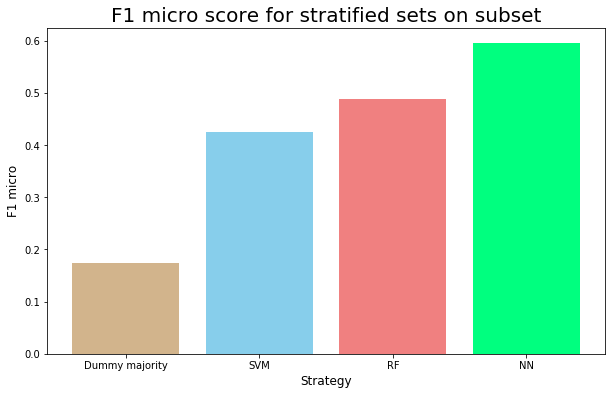

In [164]:
height = [0.174,0.424, 0.488, 0.595]
city=['Dummy majority','SVM','RF','NN']
pos = np.arange(len(height))
colors = ['tan','skyblue', 'lightcoral', 'springgreen']
plt.bar(pos,height,color=colors)
plt.xticks(pos, city)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('F1 micro', fontsize=12)
plt.title('F1 micro score for stratified sets on subset',fontsize=20)
plt.show()

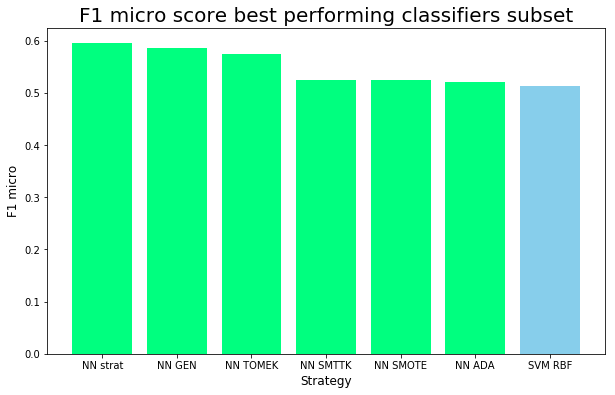

In [31]:
height = [0.595, 0.586, 0.575, 0.525, 0.524, 0.521, 0.513]
city=['NN strat', 'NN GEN', 'NN TOMEK', 'NN SMTTK', 'NN SMOTE', 'NN ADA', 'SVM RBF']
pos = np.arange(len(height))
colors = ['springgreen','springgreen','springgreen', 'springgreen', 'springgreen', 'springgreen', 'skyblue']
plt.bar(pos,height,color=colors)
plt.xticks(pos, city)
plt.xlabel('Strategy', fontsize=12)
plt.ylabel('F1 micro', fontsize=12)
plt.title('F1 micro score best performing classifiers subset',fontsize=20)
plt.rcParams['figure.figsize'] = (10,6)
plt.show()

In [27]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[13775     0    22     0     2     0     0     0     0     3     0     0
      0     0     1     0     0     0     1     0     0     0     0     0
      0     1     0     0     0     0     4     0    21     4     0     0
      0     0     0     1     0    15     0     0     0     2     0     0
      0     3     0     0     0     0     0     0    21     0     0     0
      4     0     1     0     0     0     0     0     0     0     0     0
      0    17     0     0     0     0     0     0]
 [  371     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     1     0  

Normalized confusion matrix
[[9.91e-01 0.00e+00 1.58e-03 0.00e+00 1.44e-04 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 2.16e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.20e-05 0.00e+00
  0.00e+00 0.00e+00 7.20e-05 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 7.20e-05 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.88e-04 0.00e+00
  1.51e-03 2.88e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 7.20e-05
  0.00e+00 1.08e-03 0.00e+00 0.00e+00 0.00e+00 1.44e-04 0.00e+00 0.00e+00
  0.00e+00 2.16e-04 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  1.51e-03 0.00e+00 0.00e+00 0.00e+00 2.88e-04 0.00e+00 7.20e-05 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 1.22e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [9.97e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+0

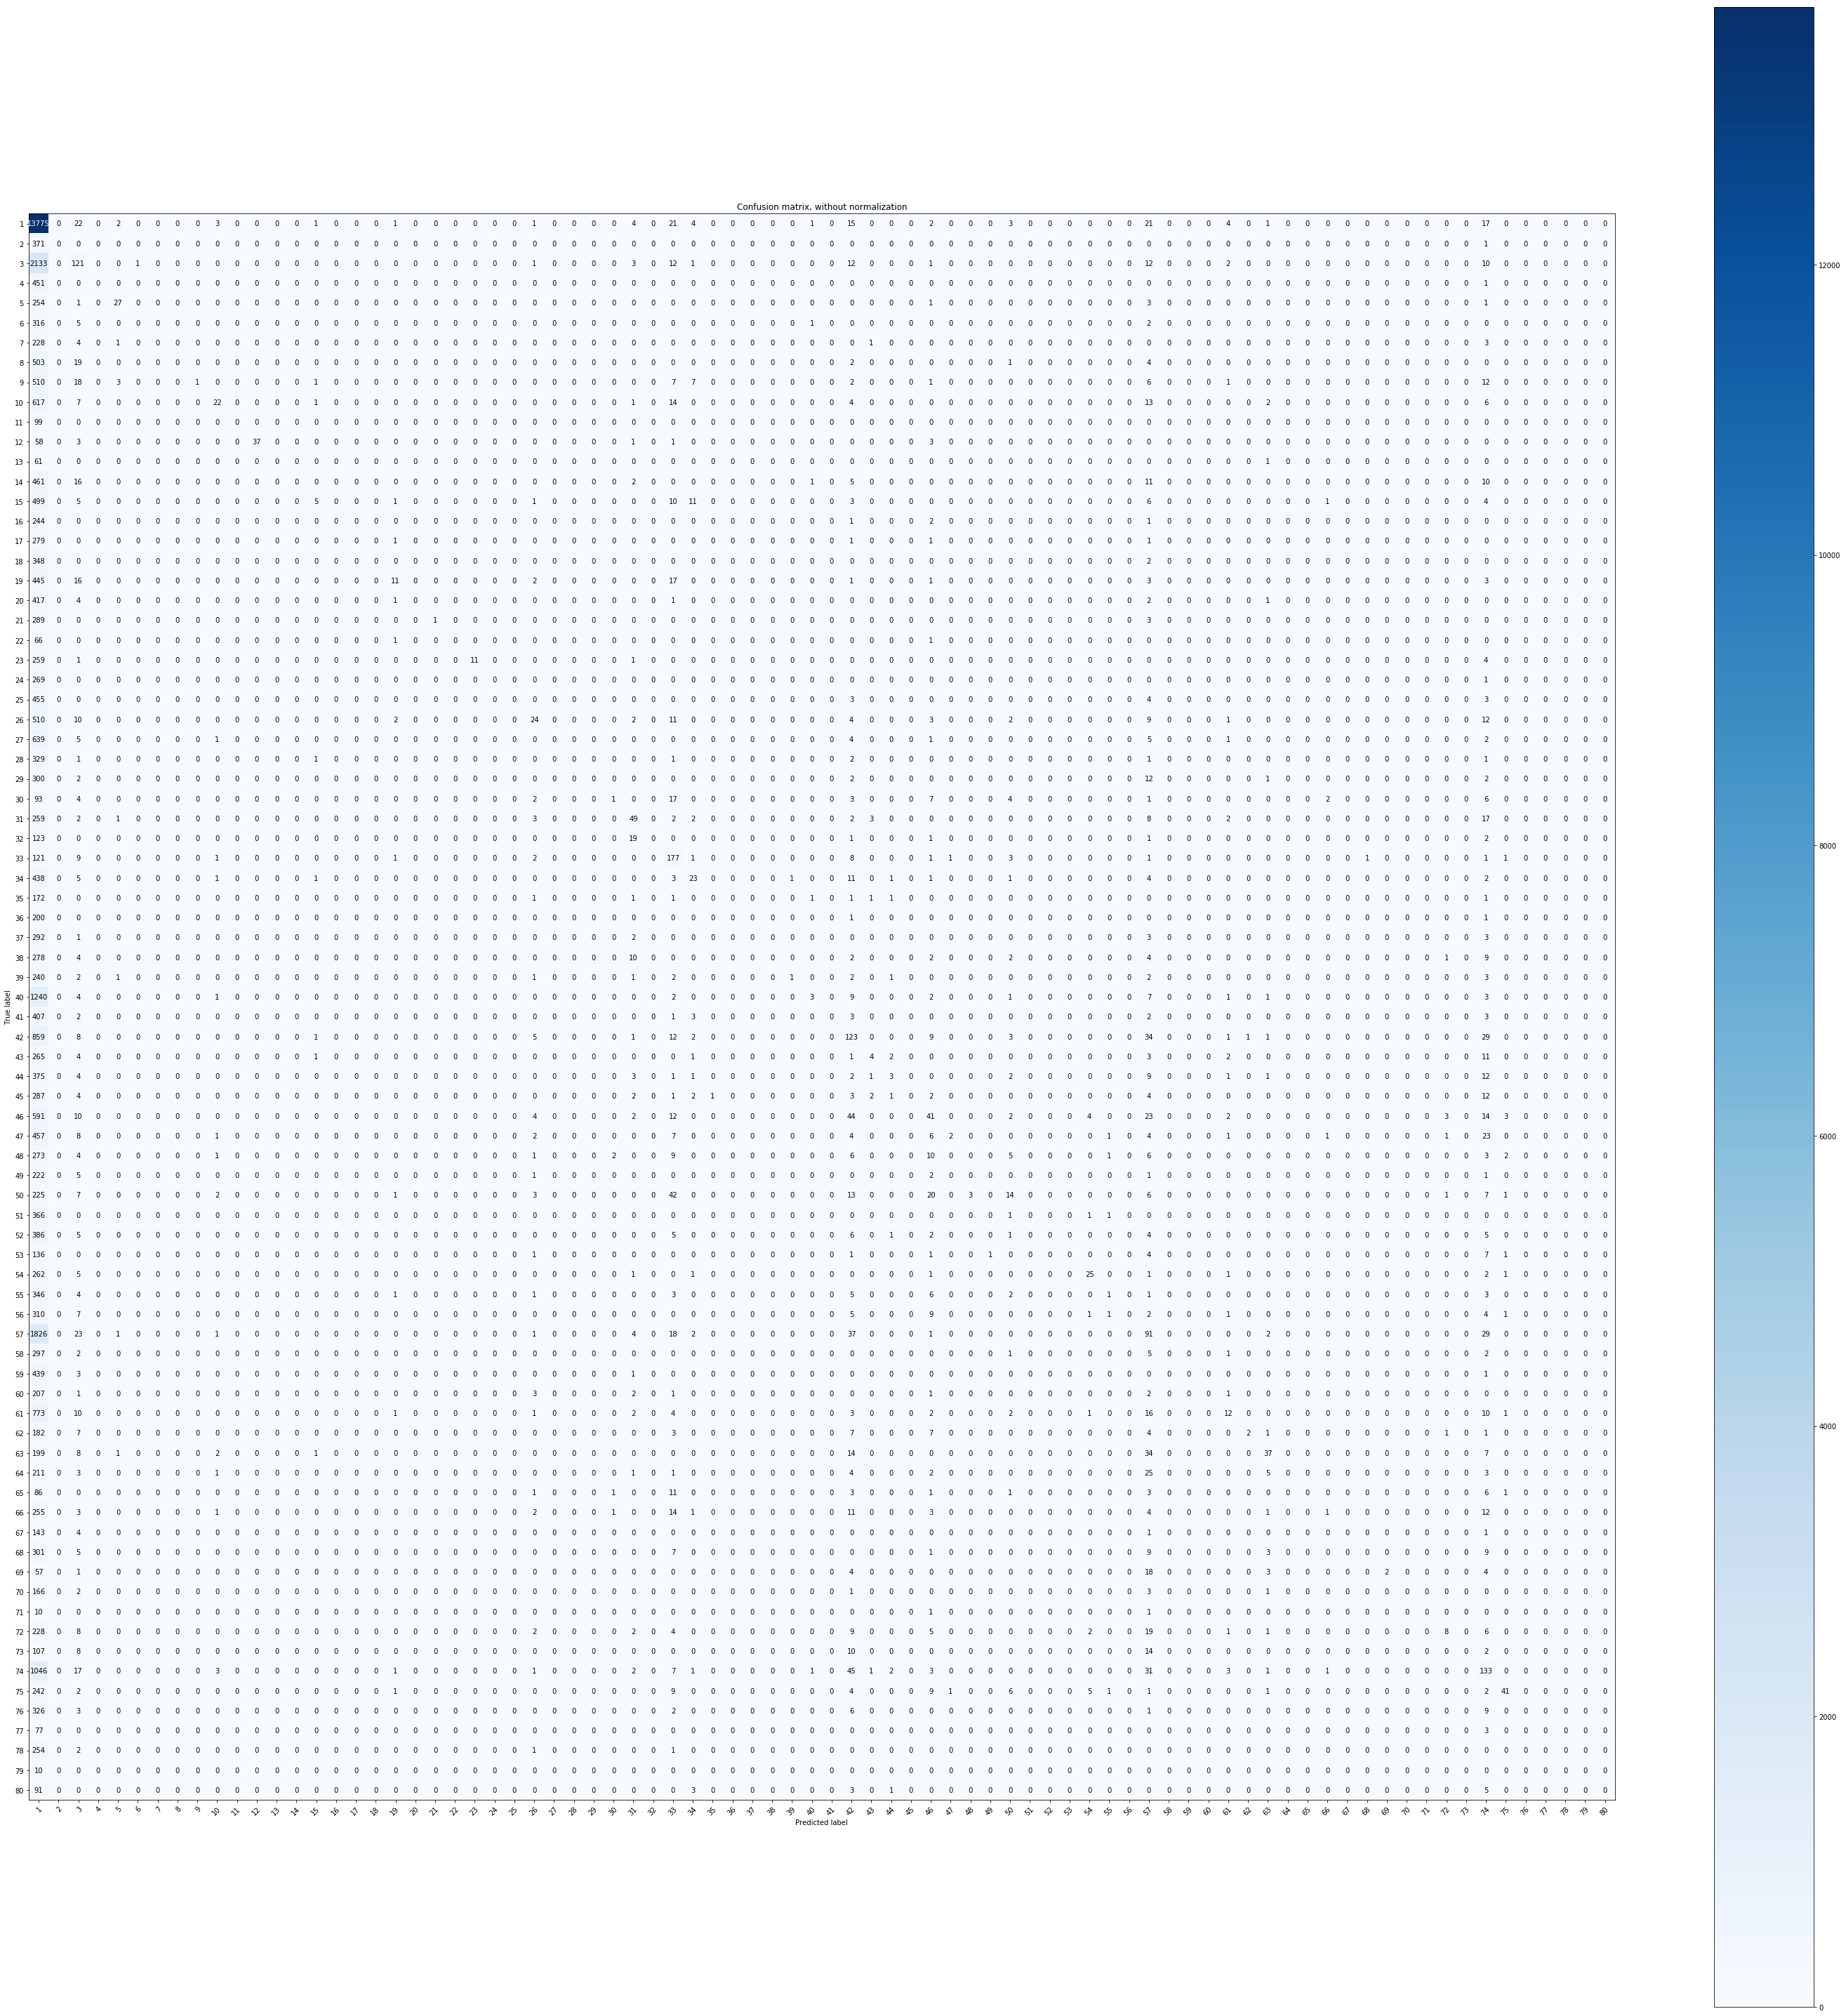

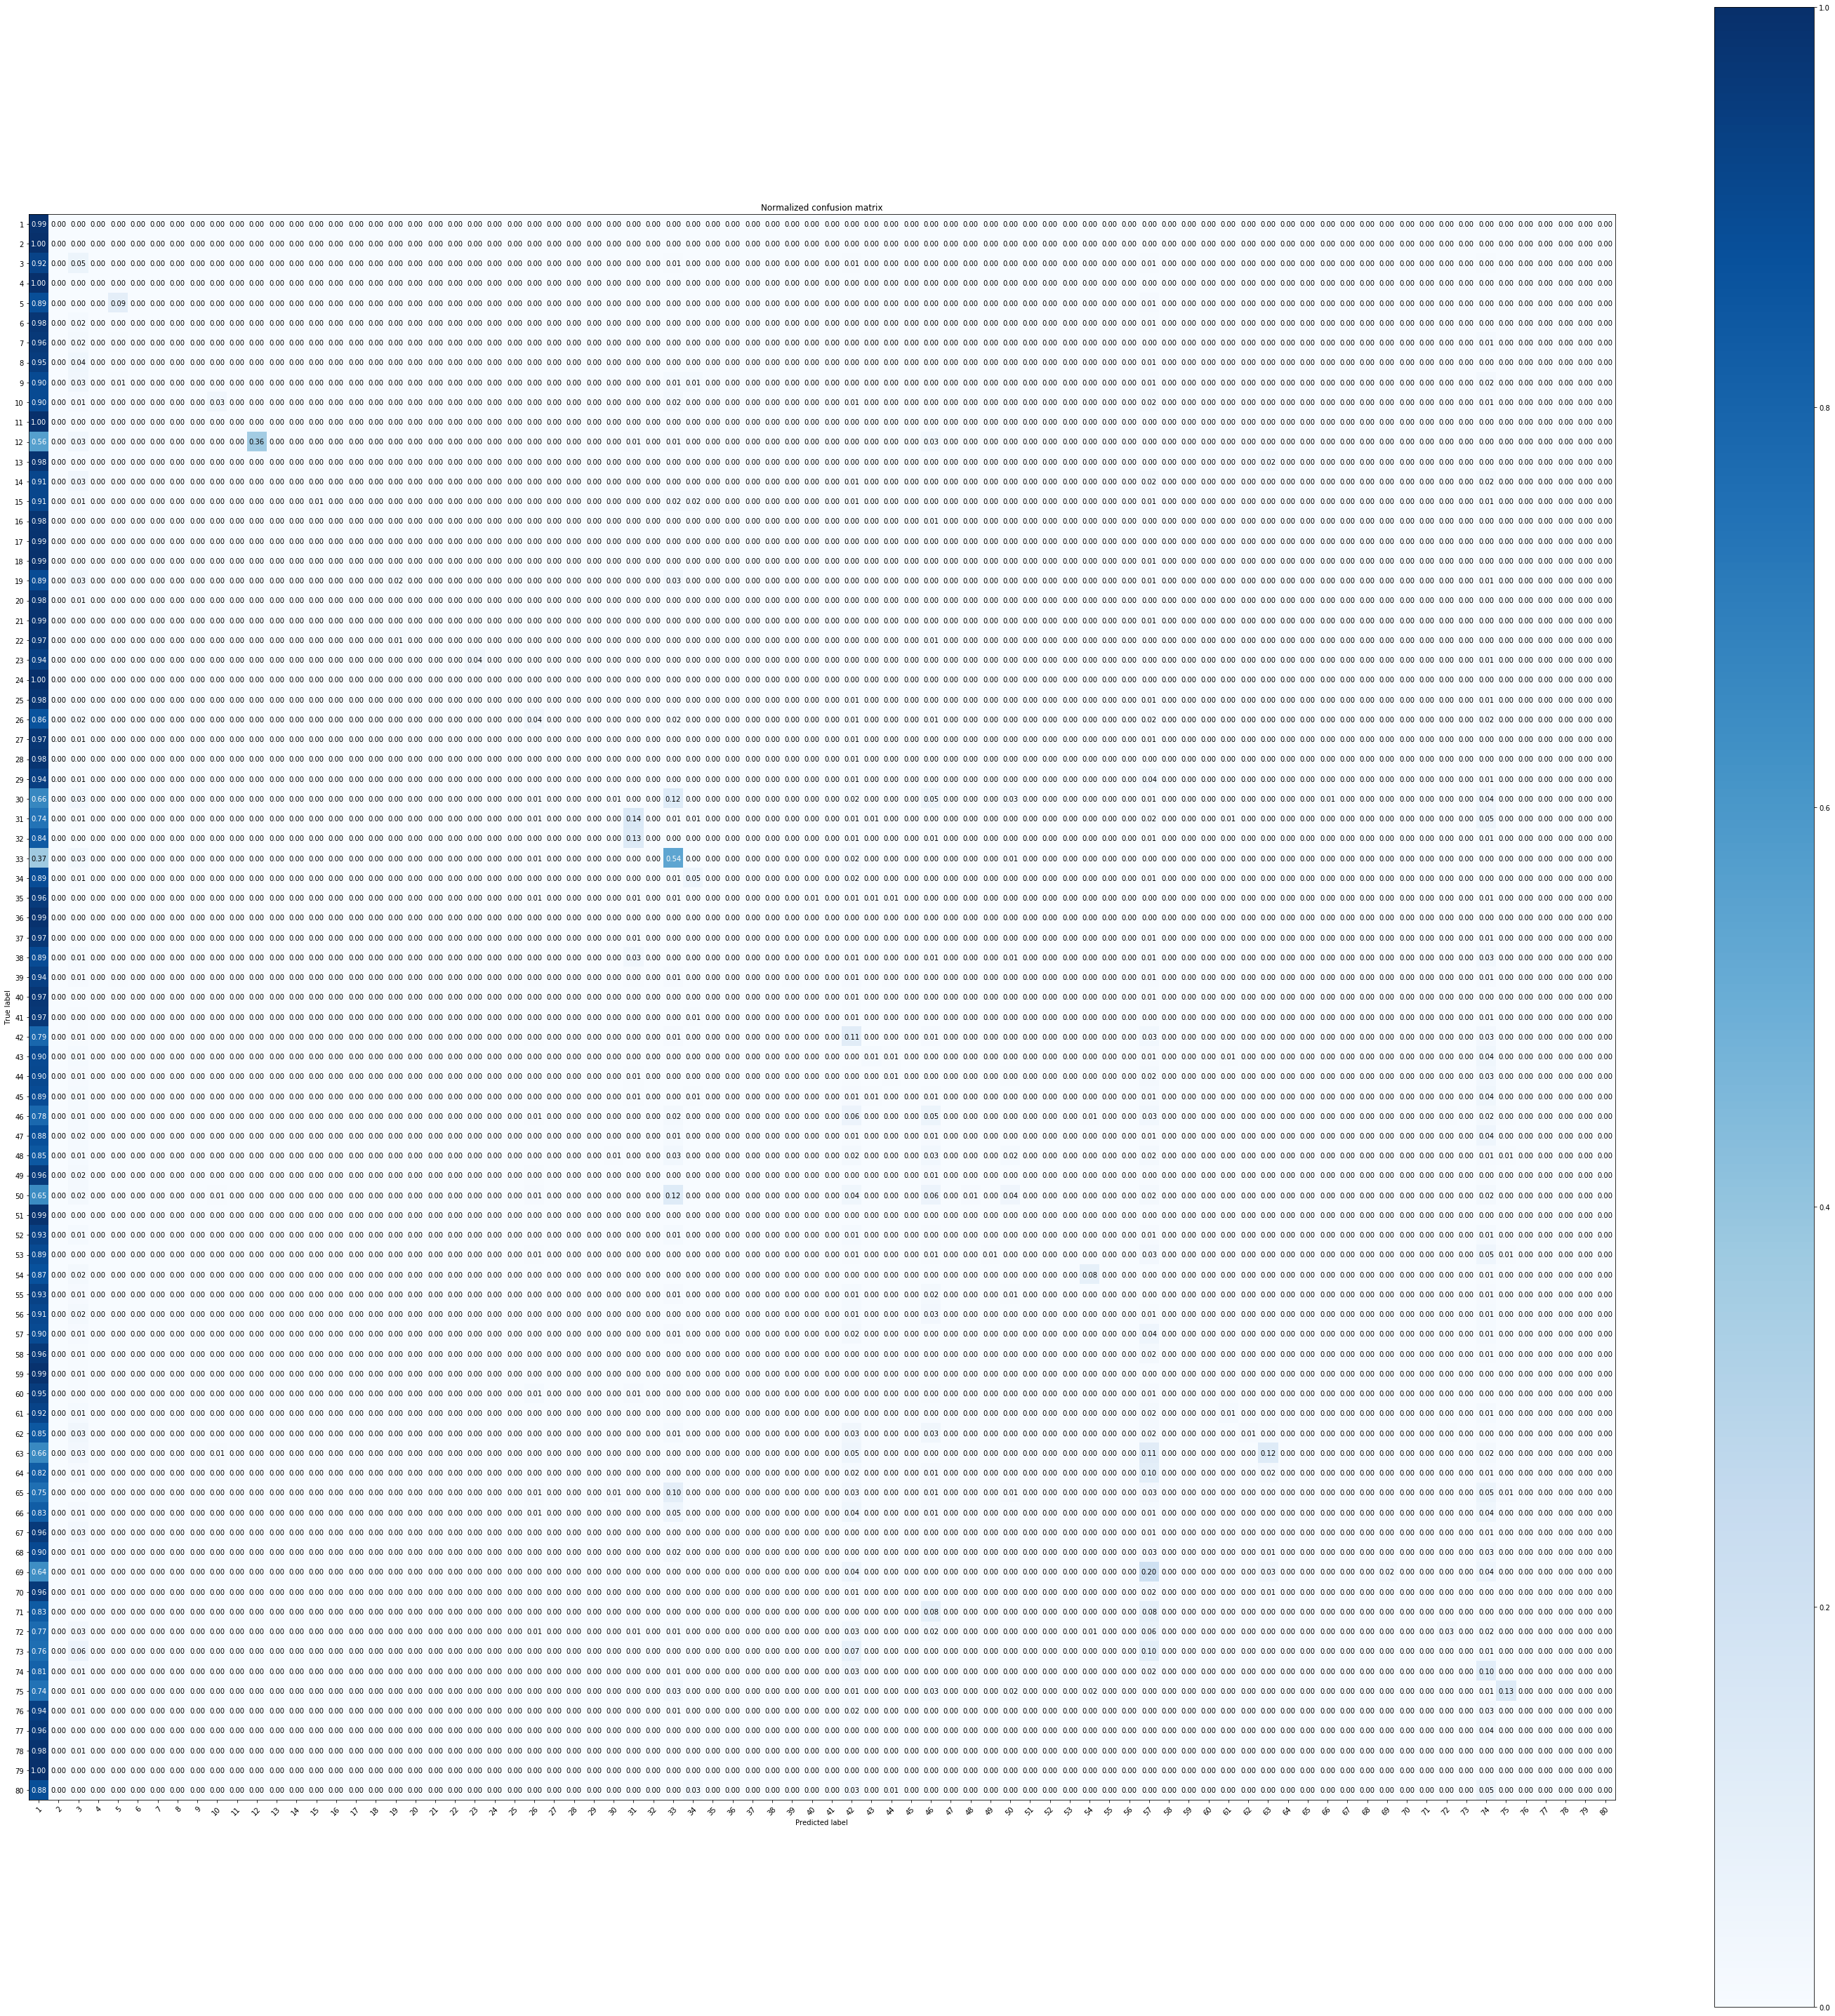

In [40]:
classes_0=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80]
# Plot non-normalized confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, classes=np.array(classes_0),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, classes=np.array(classes_0), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [43]:
plt.figure(figsize=(3,6))
plt.show()

<Figure size 216x432 with 0 Axes>

In [41]:
bounded_annotations_train = joblib.load('outputs/bounded_annotations_train_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')
bounded_annotations_val = joblib.load('outputs/bounded_annotations_val_2,11,14,17,23,34,36,39,58,65,74,76,78,80,89,90.npy')

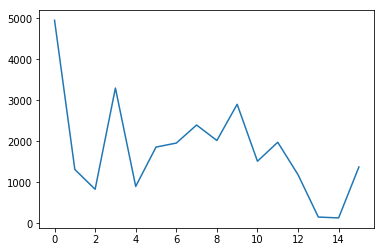

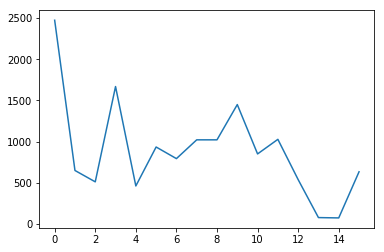

<Figure size 432x288 with 0 Axes>

In [49]:
class_counts = [4955,1316,833,3301,903,1862,1960,2400,2023,2905,1517,1980,1189,156,135,1377]
class_counts_val = [2474,650,512,1669,462,935,794,1022,1022,1450,851,1028,539,78,74,634]
plt.figure(1)
plt.plot([i for i in class_counts])
plt.show()
plt.savefig('class_counts_subset.png')
plt.plot([i for i in class_counts_val])
plt.show()
plt.savefig('class_counts_val_subset.png')

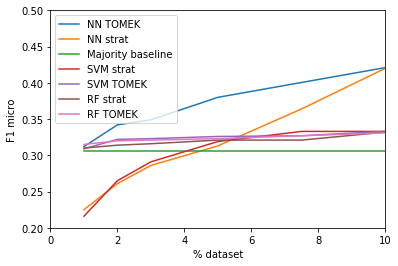

In [28]:
nn_tomek, = plt.plot([1,2,3,5,10], [0.312,0.342,0.349,0.380,0.421], label='NN TOMEK')
nn_strat, = plt.plot([1,2,3,5,7.5,10],[0.225,0.261,0.286,0.313,0.364,0.420], label='NN strat')
baseline, = plt.plot([1,2,3,5,7.5,10],[0.306,0.306,0.306,0.306,0.306,0.306], label='Majority baseline')
SVM_strat, = plt.plot([1,2,3,5,7.5,10],[0.216,0.265,0.291,0.319,0.333,0.333], label='SVM strat')
SVM_tomek, = plt.plot([1,2,3,5,7.5,10],[0.309,0.322,0.323,0.326,0.327,0.333], label='SVM TOMEK')
RF_strat, = plt.plot([1,2,3,5,7.5,10],[0.310,0.314,0.316,0.321,0.321,0.332], label='RF strat')
RF_tomek, = plt.plot([1,2,3,5,7.5,10],[0.315,0.320,0.321,0.323,0.327,0.331], label='RF TOMEK')
plt.ylabel('F1 micro')
plt.xlabel('% dataset')
plt.axis([0, 10, 0.2, 0.5])
plt.legend(handles=[nn_tomek, nn_strat,baseline,SVM_strat, SVM_tomek, RF_strat, RF_tomek])
plt.show()

In [ ]:
dataset_size = images_train.shape[0]
imgs_flat = images_train.reshape(dataset_size,-1)

In [ ]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=80,
    random_state=42,
).fit_transform(imgs_flat)
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1],
            c=bounded_annotations_train, s=0.1, cmap='Spectral')
#kmeans_labels = cluster.KMeans(n_clusters=5).fit_predict(imgs_flat)
#plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral')
#lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=500).fit_predict(lowd_train)

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=bounded_annotations_train, s=0.1, cmap='Spectral');

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=80).fit_predict(imgs_flat)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

In [ ]:
clustering_rand_score = adjusted_rand_score(bounded_annotations_train, kmeans_labels),
clustering_MI = adjusted_mutual_info_score(bounded_annotations_train, kmeans_labels)


In [ ]:
lowd_train = PCA(n_components=50).fit_transform(imgs_flat)
kmeans_labels_pca = cluster.KMeans(n_clusters=80).fit_predict(lowd_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels_pca, s=0.1, cmap='Spectral')
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_mnist)

In [ ]:
kmeansPCA = plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels_pca, s=0.1, cmap='Spectral')

In [27]:
macro_prec = [0.257,0.278,0.260,0.260]
macro_rec = [0.176,0.171,0.187,0.187]
macro_f1 = [0.190,0.185,0.198,0.198]
weighted_prec = [0.359,0.363,0.362,0.362]
weighted_rec = [0.416,0.417,0.425,0.425]
weighted_f1 = [0.361,0.352,0.367,0.367]
micro = [0.416,0.417,0.425,0.425]
metrics = [macro_prec,macro_rec,macro_f1,weighted_prec,weighted_rec,weighted_f1,micro]
for metric in metrics:
    print("mean", mean(metric))
    print("stdev", stdev(metric))

mean 0.26375000000000004
stdev 0.009604686356149281
mean 0.18025
stdev 0.008057087976847876
mean 0.19275
stdev 0.006396613687465169
mean 0.3615
stdev 0.0017320508075688787
mean 0.42074999999999996
stdev 0.0049244289008980565
mean 0.36175
stdev 0.0070887234393789186
mean 0.42074999999999996
stdev 0.0049244289008980565


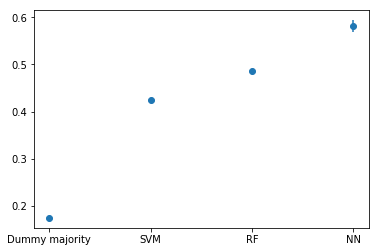

In [25]:
x = ['Dummy majority', 'SVM', 'RF', 'NN']
y = [0.174, 0.424, 0.486, 0.581]
e = [0, 0, 0.002, 0.013]
plt.errorbar(x, y, yerr=e, fmt='o')
plt.show()